# Image processing and data augmentation

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os
import ast
import albumentations as A
from tqdm import tqdm

## Labeling

Since I couldn't find an open-source Chinese sign language YOLOv5 dataset online, I learned to use the annotation tool [LabelMe](https://github.com/labelmeai/labelme) and manually annotated each image in the original dataset.

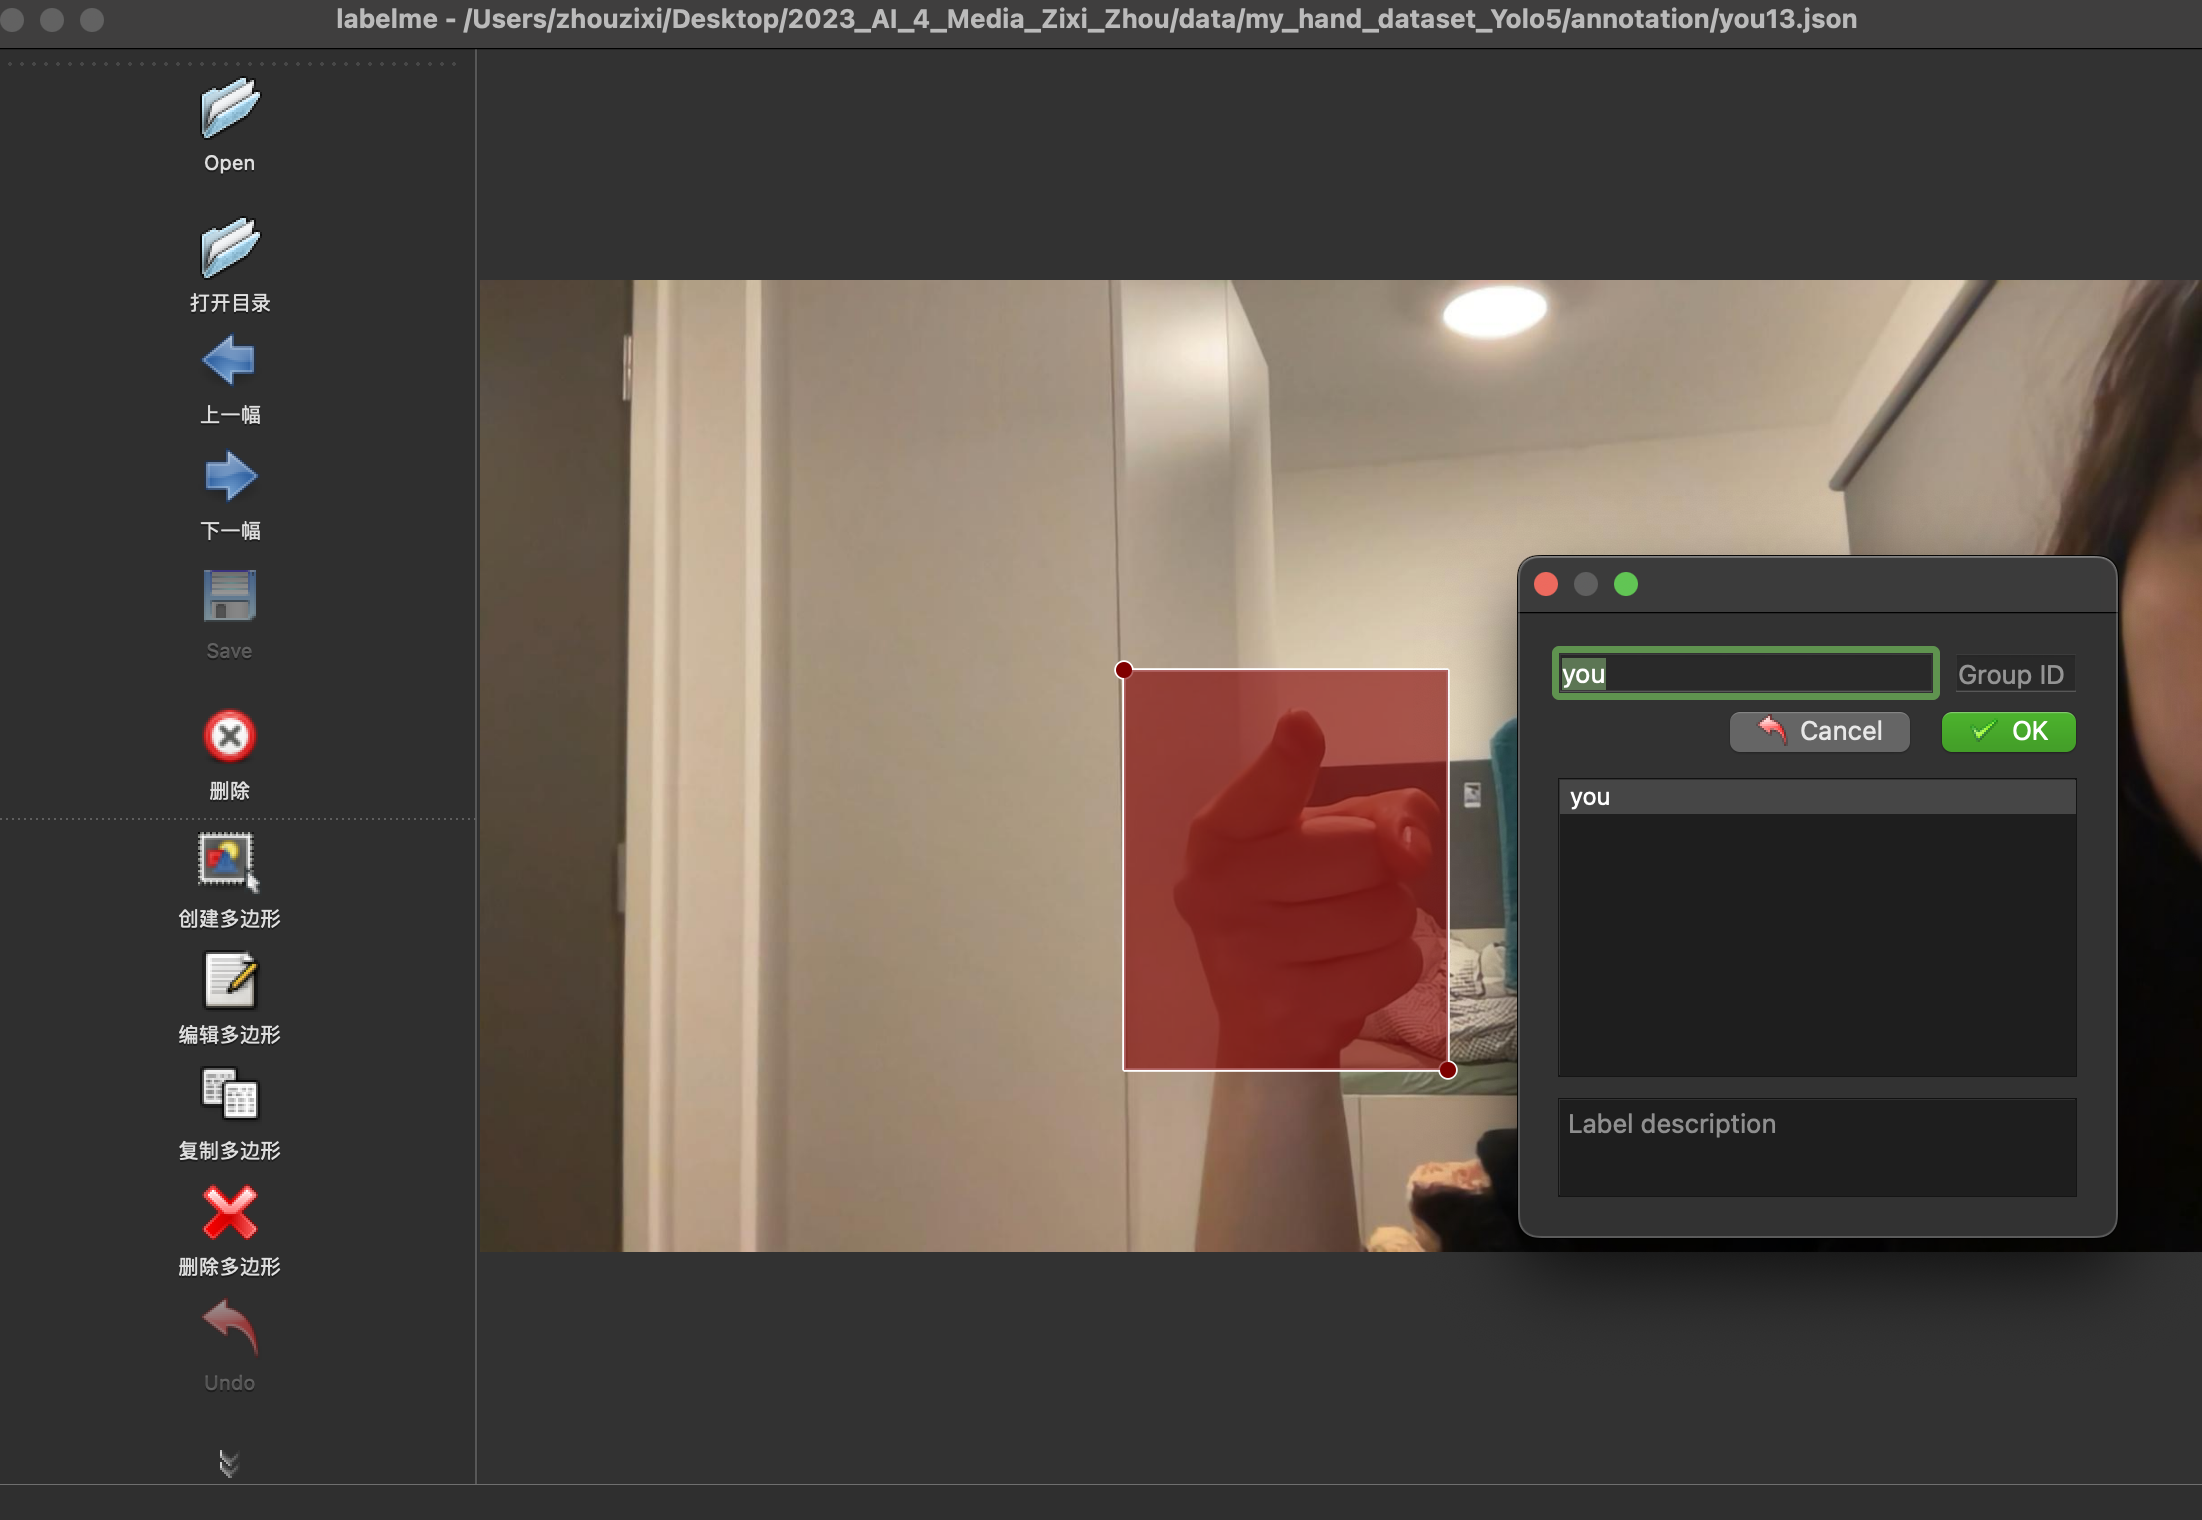

# Change .json into .txt (yolo5)

After annotating all the original images using LabelMe, the label data obtained is in **.json** format, while YOLOv5 accepts **.txt** format. Therefore, I need to perform format conversion. The following code is from [Tutorial on Converting json to txt format in LabelMe Annotation](https://blog.csdn.net/qq_42046837/article/details/120278209):

In [ ]:
import json
import os
import cv2

img_folder_path = r"data/my_hand_dataset_Yolo5/imgs"
folder_path = r"data/my_hand_dataset_Yolo5/annotation" 
txt_folder_path = r"data/my_hand_dataset_Yolo5/textlabel" 

# Mapping from category names to label numbers
class_label_map = {'arrive': 0, 'food': 1, 'good': 2, 'you': 3}

# Codes from: https://blog.csdn.net/qq_42046837/article/details/120278209 
# Save in relative coordinate format:label x_center y_center w h
def relative_coordinate_txt(img_name, json_d, img_path):
    src_img = cv2.imread(img_path)
    h, w = src_img.shape[:2]
    txt_name = os.path.splitext(img_name)[0] + ".txt"
    txt_path = os.path.join(txt_folder_path, txt_name)
    with open(txt_path, 'w') as f:
        for item in json_d["shapes"]:
            point = item['points']
            x_center = (point[0][0] + point[1][0]) / 2
            y_center = (point[0][1] + point[1][1]) / 2
            width = point[1][0] - point[0][0]
            height = point[1][1] - point[0][1]
            class_name = item['label']
            class_label = class_label_map.get(class_name, 0)  # Default to 0 if the category is not in the mapping
            f.write(" {} ".format(class_label))
            f.write(" {} ".format(x_center / w))
            f.write(" {} ".format(y_center / h))
            f.write(" {} ".format(width / w))
            f.write(" {} ".format(height / h))
            f.write(" \n")

# Iterate through all JSON files in the annotation folder
for jsonfile in os.listdir(folder_path):
    temp_path = os.path.join(folder_path, jsonfile)
    # Continue if it is a subdirectory
    if os.path.isdir(temp_path):
        continue
    print("json_path:\t", temp_path)
    with open(temp_path, "r", encoding='utf-8') as f:
        json_d = json.load(f)
        img_name = os.path.basename(json_d['imagePath'])
        img_path = os.path.join(img_folder_path, img_name)
        print("img_path:\t", img_path)
        relative_coordinate_txt(img_name, json_d, img_path)

json_path:	 data/my_hand_dataset_Yolo5/annotation/food12.json
img_path:	 data/my_hand_dataset_Yolo5/imgs/food12.jpg
json_path:	 data/my_hand_dataset_Yolo5/annotation/you11.json
img_path:	 data/my_hand_dataset_Yolo5/imgs/you11.jpg
json_path:	 data/my_hand_dataset_Yolo5/annotation/you8.json
img_path:	 data/my_hand_dataset_Yolo5/imgs/you8.jpg
json_path:	 data/my_hand_dataset_Yolo5/annotation/arrive0.json
img_path:	 data/my_hand_dataset_Yolo5/imgs/arrive0.jpg
json_path:	 data/my_hand_dataset_Yolo5/annotation/food3.json
img_path:	 data/my_hand_dataset_Yolo5/imgs/food3.jpg
json_path:	 data/my_hand_dataset_Yolo5/annotation/good3.json
img_path:	 data/my_hand_dataset_Yolo5/imgs/good3.jpg
json_path:	 data/my_hand_dataset_Yolo5/annotation/you4.json
img_path:	 data/my_hand_dataset_Yolo5/imgs/you4.jpg
json_path:	 data/my_hand_dataset_Yolo5/annotation/you5.json
img_path:	 data/my_hand_dataset_Yolo5/imgs/you5.jpg
json_path:	 data/my_hand_dataset_Yolo5/annotation/food2.json
img_path:	 data/my_hand_dat

## Load Images

Now, I have around 15 original images for each of my four hand gestures (I deleted a few blurry images). However, this is not sufficient for training the model, so I need to perform some data augmentation. The following codes are learned from the blog: [Interactive_ABCs_with_American_Sign_Language_using_Yolov5](https://github.com/insigh1/Interactive_ABCs_with_American_Sign_Language_using_Yolov5/tree/master).

First, let's take an example with one image.

In [3]:
image = cv2.imread('data/my_hand_dataset_Yolo5/imgs/arrive0.jpg')

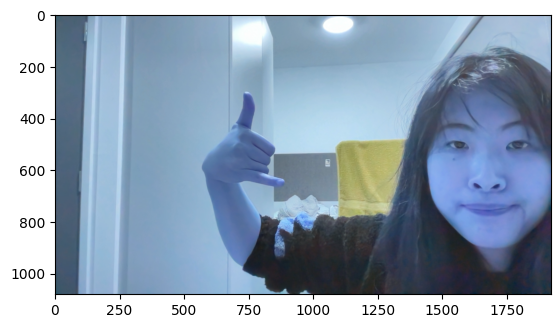

In [4]:
plt.imshow(image)

Here, I have ensured the dimensions and proportions of all my images. When augmenting the images later, I will also maintain the dimensions of 1980 x 1080. 

In [5]:
image.shape

(1080, 1920, 3)

In [6]:
load_bboxes = np.genfromtxt('data/my_hand_dataset_Yolo5/textlabel/arrive0.txt')
load_bboxes = list(load_bboxes)
bbox_cat = int(load_bboxes[0])
bboxes = load_bboxes[1:]
bboxes

[0.37789351851851855,
 0.4495884773662551,
 0.1817129629629629,
 0.36419753086419754]

In [7]:
bbox_cat

0

In [8]:
load_bboxes

[0.0,
 0.37789351851851855,
 0.4495884773662551,
 0.1817129629629629,
 0.36419753086419754]

In [9]:
# Image info
img_ht = int(image.shape[0])
img_wd = int(image.shape[1])
bb_width = int(round(bboxes[2] * image.shape[1], 0))
bb_height = int(round(bboxes[3] * image.shape[0], 0))

print(f'Image height: {img_ht}')
print(f'Image width: {img_wd}')
print(f'Bbox height: {bb_height}')
print(f'Bbox width: {bb_width}')

Image height: 1080
Image width: 1920
Bbox height: 393
Bbox width: 349


In [10]:
# pascal_voc format 
x_min = int((img_wd * bboxes[0]) - (bb_width/2))
x_max = int((img_wd * bboxes[0]) + (bb_width/2))
y_min = int(img_ht * bboxes[1] - (bb_height/2))
y_max = int(img_ht * bboxes[1] + (bb_height/2))
new_bboxes = [x_min, y_min, x_max, y_max]
print(f'Bbox x_min: {x_min}')
print(f'Bbox x_max: {x_max}')
print(f'Bbox y_min: {y_min}')
print(f'Bbox y_max: {y_max}')
print(f'new_bboxes: {new_bboxes}')

Bbox x_min: 551
Bbox x_max: 900
Bbox y_min: 289
Bbox y_max: 682
new_bboxes: [551, 289, 900, 682]


## Show image and Bounding Box

In [28]:
# Inspired by Venelin Valkov
# Source: https://www.curiousily.com/posts/image-data-augmentation-for-tensorflow-2-keras-and-pytorch-with-albumentations-in-python/
# All four classes
category_id_to_name = {0: 'arrive', 
                       1: 'food',
                       2: 'good',
                       3: 'you',
                       }
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255) # White

def show_image(image, bbox, bbox_cat, category_id_to_name):
    class_name = category_id_to_name[bbox_cat]
    image = visualize_bbox(image.copy(), bbox, class_name)
    f = plt.figure(figsize=(10,10))
    plt.imshow(
        cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        interpolation='nearest'
    )
    plt.axis('off')
    f.tight_layout()
    plt.show()
    
def visualize_bbox(image, bbox, class_name, color=BOX_COLOR, thickness=4):
    x_min, y_min, x_max, y_max = map(lambda v: int(v), bbox)
    
    cv2.rectangle(
        image,
        (x_min, y_min),
        (x_max, y_max),
        color=color,
        thickness=thickness
    )
        
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 2.7, 3)    
    cv2.rectangle(image, (x_min, y_min - int(1.2 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        image,
        text= category_id_to_name[bbox_cat],
        org=(x_min, y_min - int(.1 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=2.35, 
        color=TEXT_COLOR,
        thickness=3,
        lineType=cv2.LINE_AA,
    )
    return image

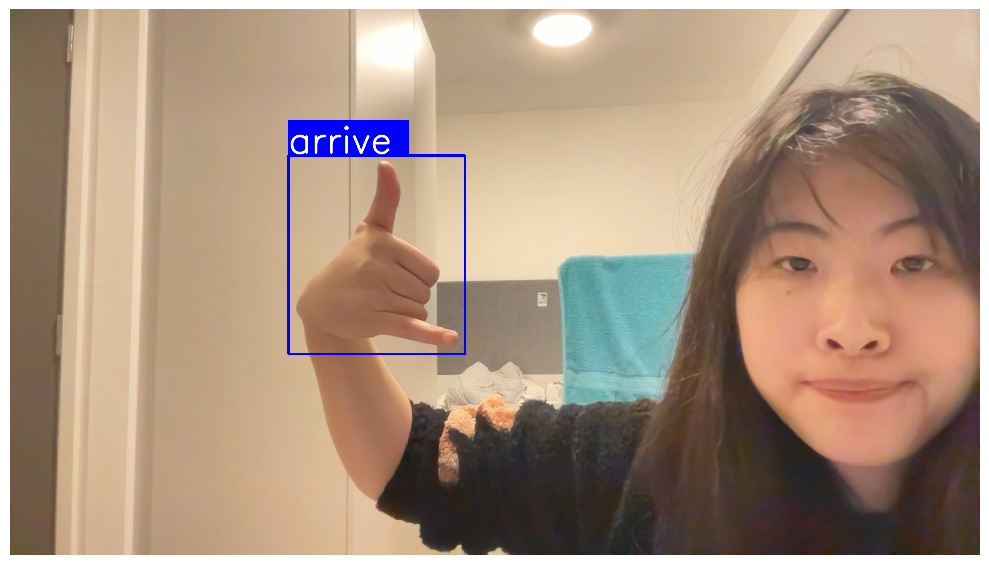

In [12]:
show_image(image, new_bboxes, bbox_cat, category_id_to_name)

## Define augmentation pipeline

In [13]:
def show_augmented(augmentation, image, bbox, class_name):
    augmented = augmentation(image=image, bboxes=[bbox], class_name=[class_name])
    show_image(augmented['image'], augmented['bboxes'][0], bbox_cat, category_id_to_name)

In [23]:
# [x_min, y_min, x_max, y_max]
bbox_params = A.BboxParams(
    format= 'pascal_voc',
    min_area=1,
    min_visibility=0.5,
    label_fields=['class_name']
)

This code snippet performs data augmentation using the Albumentations library. It includes various operations such as resizing images, padding, shifting, scaling, rotating, cropping, flipping, adjusting brightness and contrast, hue, saturation, and value, adding Gaussian noise, and blurring. These operations help increase the diversity of the dataset and improve the model's generalization capability.

While running this piece of code, I used ChatGPT to assist me with debugging.

In [27]:
# Source: https://github.com/albumentations-team/albumentations_examples/blob/master/notebooks/example_bboxes.ipynb
import albumentations as A
import cv2
import os

aug = A.Compose([
    A.LongestMaxSize(max_size=1920), 
    A.PadIfNeeded(min_height=1080, min_width=1920, border_mode=0, p=1.0),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
    A.RandomSizedCrop((900, 1000), 1080, 1920, p=0.2),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), mean=0, always_apply=False, p=0.5),
    A.Blur(blur_limit=3, p=0.5),
    A.NoOp(p=0.04)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_name'])) 


## Apply the augmentation pipeline to it 4 times

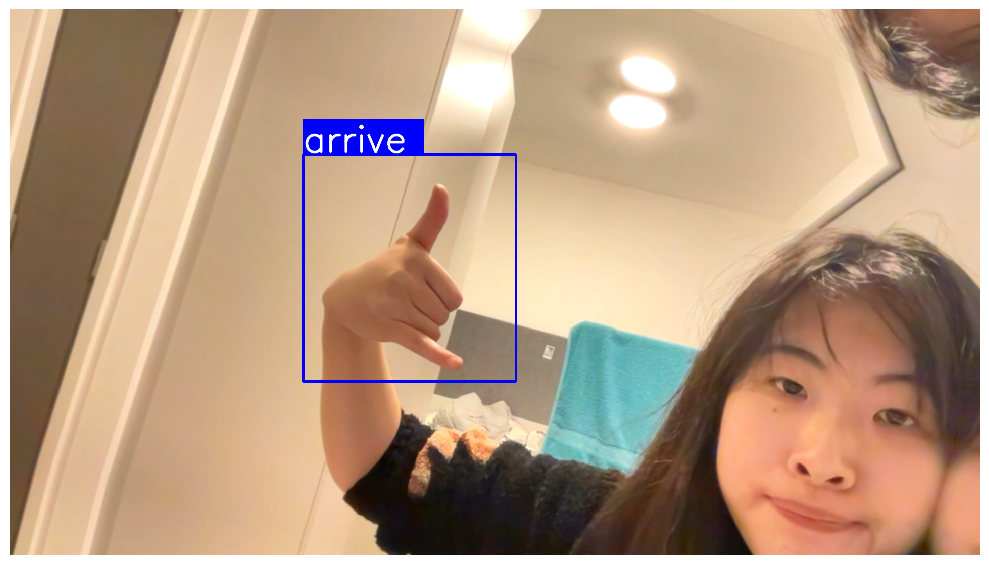

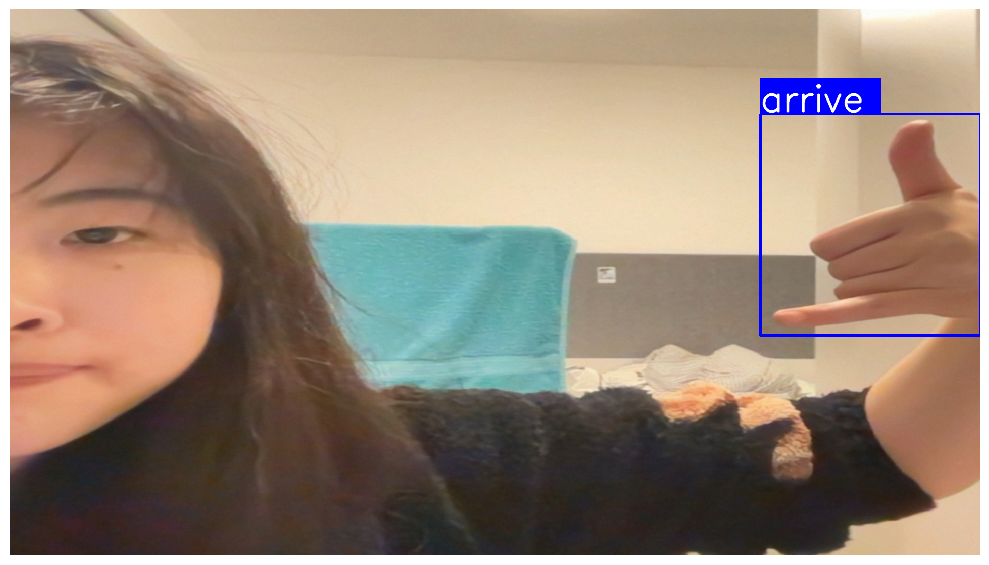

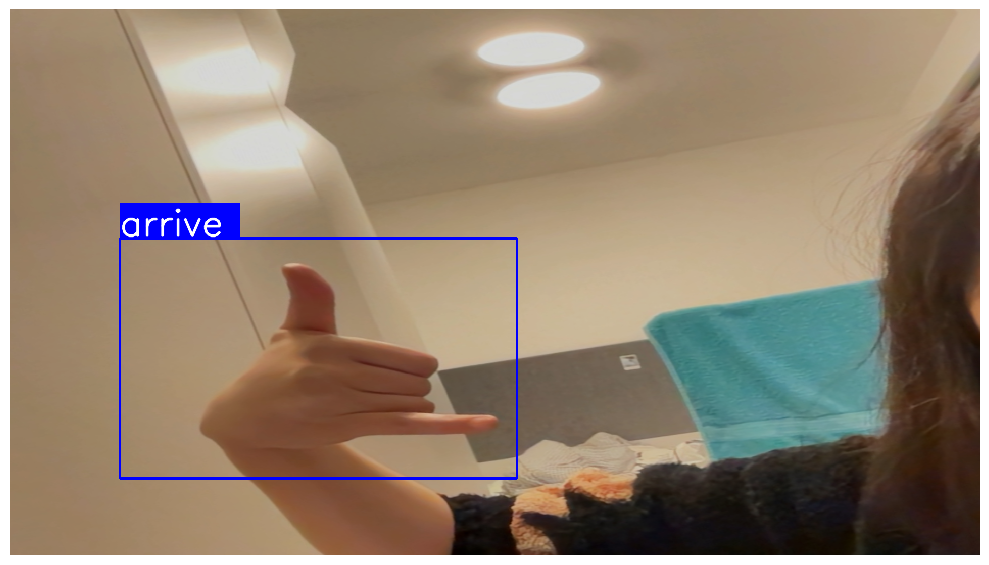

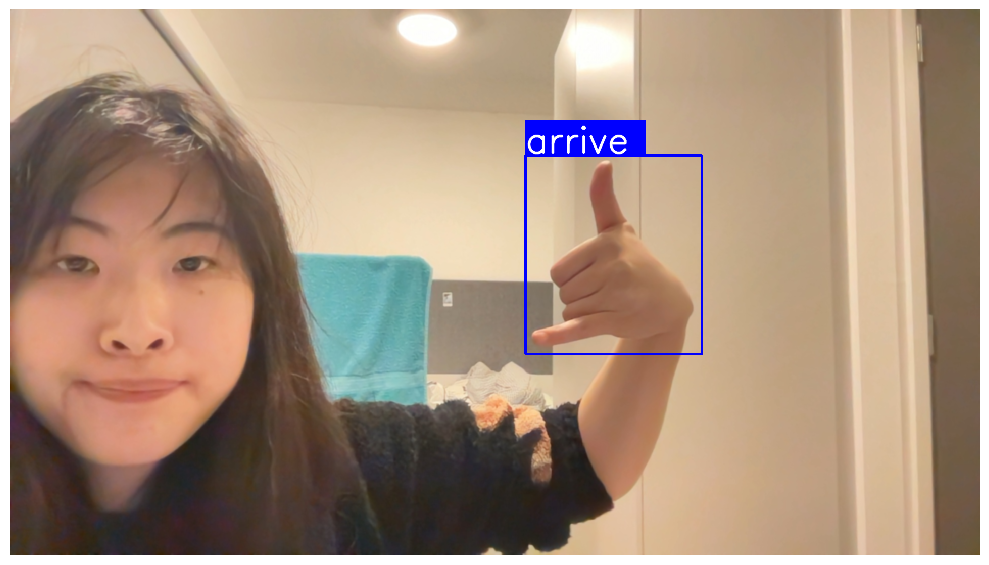

In [25]:
for i in range(4):
    show_augmented(aug, image, new_bboxes, category_id_to_name)

## Creating Augmented Dataset


I want approximately 300 images for each class, so I will augment each original image around 20 times.

In [113]:
import os
import cv2
import numpy as np
import pandas as pd
import albumentations as A

path_sign_language_letter_request = 'data/my_hand_dataset_Yolo5/imgs/'
path_labels = 'data/my_hand_dataset_Yolo5/textlabel/'
DATASET_PATH = 'aug_data'
IMAGES_PATH = f'{DATASET_PATH}/images'
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(IMAGES_PATH, exist_ok=True)

aug = A.Compose([
    A.LongestMaxSize(max_size=1920),  
    A.PadIfNeeded(min_height=1080, min_width=1920, border_mode=0, p=1.0),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
    A.RandomSizedCrop((900, 1000), 1080, 1920, p=0.2),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), mean=0, always_apply=False, p=0.5),
    A.Blur(blur_limit=3, p=0.5),
    A.NoOp(p=0.04)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_name']))


rows = []

for filename in os.listdir(path_sign_language_letter_request):
    # Load images
    img_path = os.path.join(path_sign_language_letter_request, filename)
    image = cv2.imread(img_path)
    
    # Read label text
    load_bboxes = np.genfromtxt(os.path.join(path_labels, filename[:-4] + '.txt'))
    bbox_cat = int(load_bboxes[0])
    bboxes = load_bboxes[1:]
    img_ht, img_wd = image.shape[:2]
    
    # New bboxes
    bb_width = int(round(bboxes[2] * img_wd, 0))
    bb_height = int(round(bboxes[3] * img_ht, 0))
    x_min = int((img_wd * bboxes[0]) - (bb_width/2))
    x_max = int((img_wd * bboxes[0]) + (bb_width/2))
    y_min = int(img_ht * bboxes[1] - (bb_height/2))
    y_max = int(img_ht * bboxes[1] + (bb_height/2))
    new_bboxes = [x_min, y_min, x_max, y_max]

    # Run 20 times for each images
    for i in range(20):
        augmented = aug(image=image, bboxes=[new_bboxes], category_ids=[bbox_cat])
        file_name = f'{filename[:-4]}_{i}.jpg'
        
        augmented_img_path = os.path.join(IMAGES_PATH, file_name)
        cv2.imwrite(augmented_img_path, augmented['image'])
        
        for bbox, category_id in zip(augmented['bboxes'], augmented['category_ids']):
            x_min, y_min, x_max, y_max = map(lambda v: int(v), bbox)
            x_center = (x_min + x_max) / 2 / img_wd
            y_center = (y_min + y_max) / 2 / img_ht
            w = (x_max - x_min) / img_wd
            h = (y_max - y_min) / img_ht
            new_bbox = [category_id, x_center, y_center, w, h]
            
            rows.append({
                'image_id': file_name,
                'bbox': new_bbox
            })

# Write annotations to CSV file
annotation_df = pd.DataFrame(rows)
annotation_df.to_csv(os.path.join(DATASET_PATH, 'annotations.csv'), header=True, index=None)

## Setting up with Yolov5:

Now that I have completed preparing the dataset, there are 1160 original images for training in the `aug_data` folder, along with their corresponding annotation information stored in `annotations.csv`. 

#### Clone Repo:

##### yolov5: https://github.com/ultralytics/yolov5

Next, run the `02_munge_data.py`  file to split the dataset into training and validation sets as required by YOLOv5. After running, the following folder structure was created:

```
yolov5  
    |__ chinese_gesture_yolo   
        |__ images  
        |   |__ train  
        |   |__ validation  
        |__ labels  
            |__ train  
            |__ validation  
```        